# (06) DOVES—CategConv—0

**Motivation**: Categorical with ```512 x 2``` (essentially Bernoulli) + DOVES + Conv encoder. ```prior_fit = True```. Device = ```cuda:0``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_PoissonVAE'))
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
device_idx = 0
device = f'cuda:{device_idx}'

model_type = 'categorical'

## Archi: ```<Conv|Lin>```

In [3]:
cfg_vae, cfg_tr = default_configs('DOVES', model_type, 'conv+b|lin')
cfg_vae['fit_prior'] = True
cfg_vae['n_categories'] = 512
cfg_vae['n_latents'] = 2

print(f"VAE:\n{cfg_vae}\n\nTrainer:\n{cfg_tr}")

VAE:
{'dataset': 'DOVES', 'n_ch': 32, 'n_latents': 2, 'n_categories': 512, 'enc_type': 'conv', 'dec_type': 'lin', 
'enc_bias': True, 'dec_bias': False, 'fit_prior': True}

Trainer:
{'temp_stop': 0.1, 'temp_anneal_portion': 1.0, 'temp_anneal_type': 'exp', 'lr': 0.005, 'batch_size': 1000, 
'epochs': 3000, 'optimizer_kws': {'weight_decay': 0.0}, 'grad_clip': 500}

+----------------+------------+
|  Module Name   | Num Params |
+----------------+------------+
| CategoricalVAE |  1.6 Mil   |
|      ---       |    ---     |
|      stem      |    352     |
|      enc       |  1.2 Mil   |
|     fc_enc     |  132.1 K   |
|     fc_dec     |  262.1 K   |
+----------------+------------+

categorical_c-512_fit-prior_DOVES_z-2_k-32_<conv+b|lin>
mc_b1000-ep3000-lr(0.005)_beta(1:0x0.5)_temp(0.1:exp-1)_gr(500)_(2024_05_06,17:20)

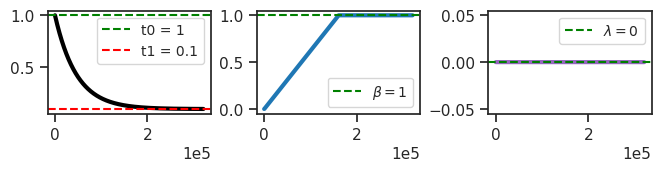

In [4]:
vae = MODEL_CLASSES[model_type](CFG_CLASSES[model_type](**cfg_vae))
tr = TrainerVAE(vae, ConfigTrainVAE(**cfg_tr), device=device)

vae.print()
print(f"{vae.cfg.name()}\n{tr.cfg.name()}_({vae.timestamp})\n")
tr.show_schedules()

### Train

In [9]:
# comment = f"..._{tr.cfg.name()}"
comment = tr.cfg.name()
tr.train(comment=comment)

epoch # 3000, avg loss: 161.723364: 100%|█████████████████████| 3000/3000 [2:23:39<00:00,  2.87s/it]


### Loss vld (freeze)

In [11]:
data, loss, etc = tr.validate()

_loss = {k: v.mean() for k, v in loss.items()}
_loss['tot'] = _loss['mse'] + _loss['kl']
print(_loss)

{'mse': 155.9464, 'kl': 11.52797, 'kl_diag': 5.758477, 'tot': 167.47437}

In [26]:
### Was: 512 x 1, fixed prior

{'mse': 165.01498, 'kl': 5.632016, 'kl_diag': 5.6216135, 'tot': 170.647}

{'mse': 134.10709, 'kl': 28.86082, 'kl_diag': 0.056184433, 'tot': 162.96791}

{'mse': 133.72597, 'kl': 28.916742, 'kl_diag': 0.05594784, 'tot': 162.64272}

{'mse': 132.80032, 'kl': 29.794188, 'kl_diag': 0.05768895, 'tot': 162.59451}

### Plot enc/dec weights

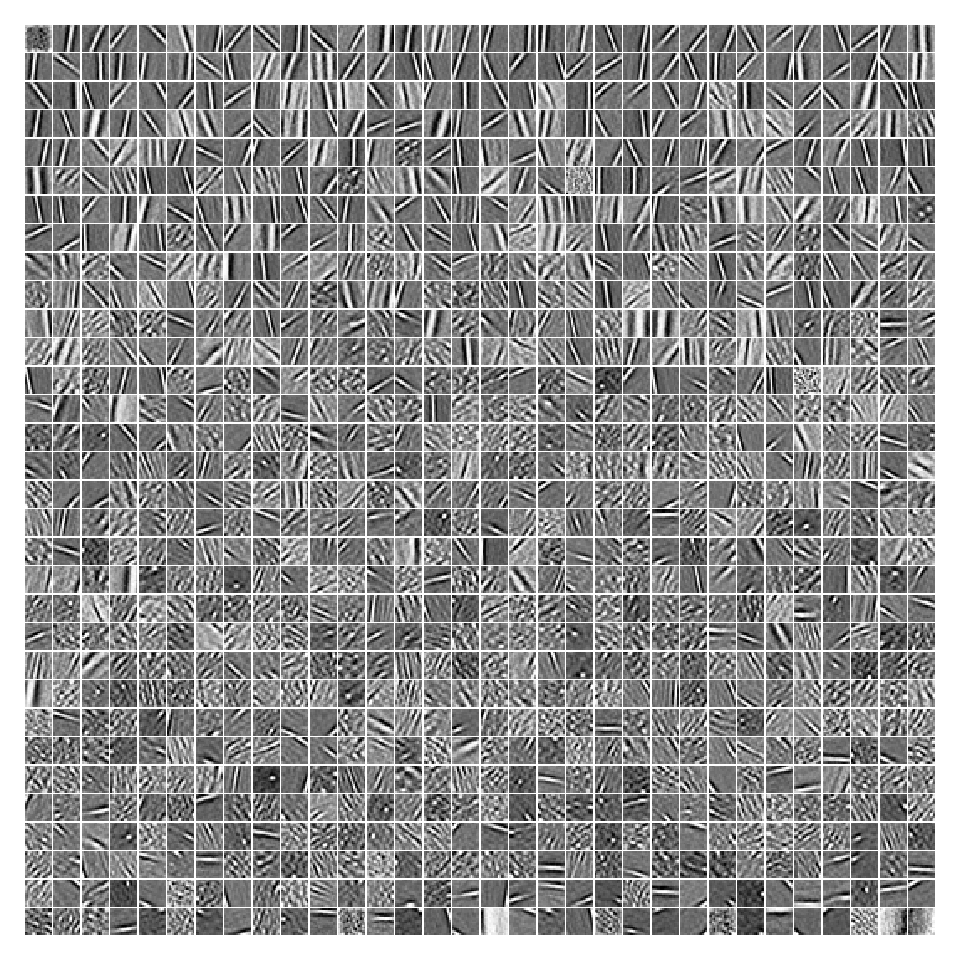

In [13]:
vae.show(dpi=250, nrows=32, order=np.argsort(flatten_np(etc['logits'], start_dim=1).mean(0)));

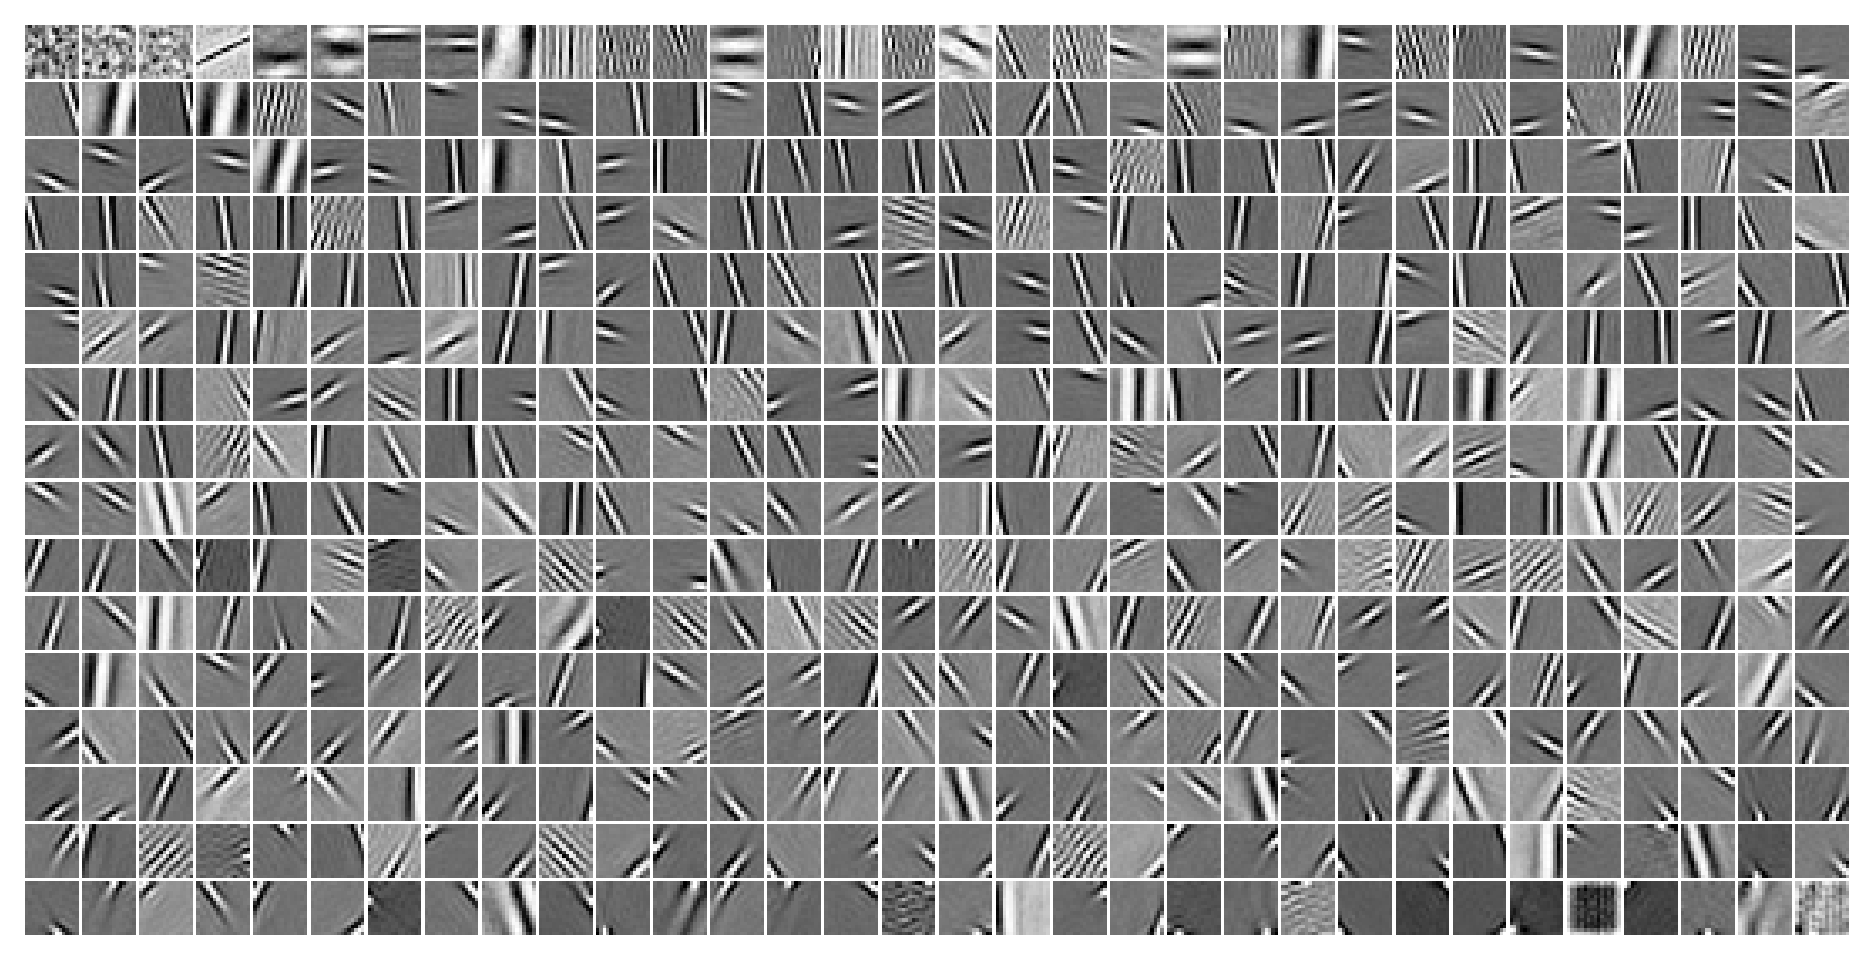

### Some more distributions

In [14]:
tr.model.temp, tr.cfg.kl_beta

(tensor(0.1009, device='cuda:0'), 1.0)

In [48]:
from base.distributions import dists

prior = dists.Categorical(vae.logits[0])
prior_probs = tonp(prior.probs).ravel()
prior_logits = tonp(prior.logits).ravel()

In [49]:
rv = sp_stats.norm(loc=prior_probs.mean(), scale=prior_probs.std())
xs = np.linspace(rv.ppf(1e-5), rv.ppf(1 - 1e-5), 101)
pdf = rv.pdf(xs)

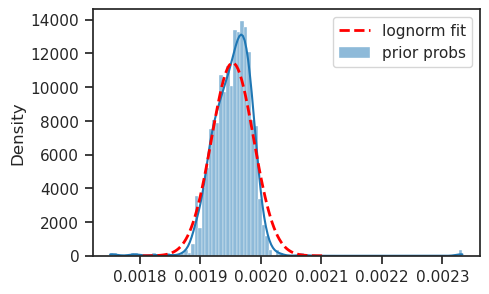

In [51]:
fig, ax = create_figure()

sns.histplot(prior_probs, stat='density', bins=100, kde=True, label='prior probs', ax=ax)
ax.plot(xs, pdf, color='r', lw=2, ls='--', label='lognorm fit')
add_legend(ax)
plt.show()

In [61]:
exclude = np.logical_or(
    prior_logits > np.quantile(prior_logits, 0.999),
    prior_logits < np.quantile(prior_logits, 1 - 0.999),
)
exclude.sum()

4

In [62]:
rv = sp_stats.norm(loc=prior_logits[~exclude].mean(), scale=prior_logits[~exclude].std())
xs = np.linspace(rv.ppf(1e-5), rv.ppf(1 - 1e-5), 101)
pdf = rv.pdf(xs)

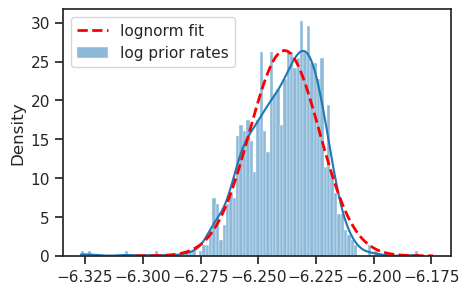

In [63]:
fig, ax = create_figure()

sns.histplot(prior_logits[~exclude], stat='density', bins=100, kde=True, label='log prior rates', ax=ax)
ax.plot(xs, pdf, color='r', lw=2, ls='--', label='lognorm fit')
add_legend(ax)
plt.show()

In [64]:
sp_stats.kstest(prior_logits[~exclude], rv.cdf, method='exact')

KstestResult(statistic=0.05526713130181016, pvalue=0.003781269503779637, statistic_location=-6.2329464, statistic_sign=-1)

## Loggabor analysis

In [67]:
dead = np.zeros(np.prod(tr.model.size)).astype(bool)

In [68]:
from analysis.loggabor import fit_loggabor
from figures.theta import plot_theta
from figures.imgs import plot_weights

In [69]:
results = fit_loggabor(tr, verbose=True)

  1%|           | 11/1024 [00:00<00:38, 26.18it/s]

  3%|▎          | 28/1024 [00:01<00:45, 22.04it/s]

  8%|▉          | 83/1024 [00:04<00:41, 22.46it/s]

  9%|█          | 97/1024 [00:05<00:46, 19.75it/s]

 20%|█▉        | 203/1024 [00:11<00:47, 17.17it/s]

 24%|██▎       | 242/1024 [00:13<00:58, 13.34it/s]

 26%|██▌       | 264/1024 [00:14<00:34, 22.14it/s]

 29%|██▊       | 293/1024 [00:15<00:30, 23.78it/s]

 31%|███       | 316/1024 [00:17<00:33, 20.97it/s]

 33%|███▎      | 342/1024 [00:19<00:28, 23.61it/s]

 36%|███▌      | 369/1024 [00:20<00:27, 24.15it/s]

 37%|███▋      | 379/1024 [00:21<00:47, 13.50it/s]

 41%|████      | 415/1024 [00:23<00:21, 28.03it/s]

 43%|████▎     | 436/1024 [00:23<00:20, 29.36it/s]

 44%|████▍     | 455/1024 [00:24<00:28, 19.98it/s]

 46%|████▌     | 466/1024 [00:25<00:21, 26.29it/s]

 53%|█████▎    | 545/1024 [00:28<00:14, 32.94it/s]

 54%|█████▎    | 549/1024 [00:28<00:15, 31.38it/s]

 55%|█████▌    | 566/1024 [00:29<00:16, 28.23it/s]

 58%|█████▊    | 595/1024 [00:30<00:21, 19.87it/s]

 64%|██████▍   | 659/1024 [00:32<00:09, 37.37it/s]

 69%|██████▉   | 707/1024 [00:34<00:10, 30.75it/s]

 71%|███████   | 728/1024 [00:35<00:12, 23.38it/s]

 73%|███████▎  | 743/1024 [00:36<00:14, 18.94it/s]

 76%|███████▌  | 774/1024 [00:37<00:09, 26.28it/s]

 78%|███████▊  | 798/1024 [00:38<00:11, 19.20it/s]

 79%|███████▊  | 805/1024 [00:38<00:10, 21.63it/s]

 84%|████████▍ | 861/1024 [00:41<00:06, 24.29it/s]

 85%|████████▌ | 873/1024 [00:41<00:06, 23.25it/s]

 86%|████████▌ | 882/1024 [00:41<00:04, 30.86it/s]

 87%|████████▋ | 887/1024 [00:42<00:04, 34.15it/s]

 88%|████████▊ | 900/1024 [00:42<00:04, 30.96it/s]

 92%|█████████▏| 946/1024 [00:44<00:03, 23.72it/s]

 94%|█████████▍| 967/1024 [00:46<00:04, 12.56it/s]

 95%|█████████▍| 971/1024 [00:46<00:04, 12.82it/s]

 96%|█████████▌| 980/1024 [00:47<00:02, 14.75it/s]

 98%|████████▊| 1006/1024 [00:47<00:00, 27.17it/s]

100%|█████████| 1024/1024 [00:49<00:00, 20.80it/s]


In [71]:
results.loc[results['sf_0'] > 10, 'sf_0'] = np.nan
results.iloc[np.logical_or(dead, np.isnan(results['theta']))] = np.nan
results.describe()

,x_pos,y_pos,theta,sf_0,phase,B_sf,B_theta,theta_deg,probs
count,9.710000e+02,971.000000,971.000000,969.000000,971.000000,971.000000,971.000000,971.000000,9.710000e+02
mean,7.401774e+00,7.503296,0.127818,0.222991,-0.095786,0.419920,0.243365,87.776549,8.793852e-11
std,3.389009e+00,3.727300,0.985170,0.075007,1.644791,1.453877,0.427352,42.967720,5.860831e-11
min,6.967084e-09,0.000000,-1.570796,0.006007,-9.376058,0.014648,0.054135,0.102013,5.832501e-13
25%,5.071140e+00,4.494178,-0.822637,0.194378,-0.866493,0.249190,0.118411,51.579492,5.621949e-11
50%,7.510276e+00,7.339146,0.442436,0.221587,-0.135517,0.359412,0.162164,82.710537,7.690794e-11
75%,9.698107e+00,10.563826,0.996647,0.247382,0.695117,0.445804,0.237957,124.315380,1.035911e-10
max,1.600000e+01,16.000000,1.570796,2.077341,7.266689,44.770599,6.057009,179.645646,1.030364e-09


In [72]:
rates_axial = results.loc[(results['label'] == 'axial') & ~dead, 'probs'].values
rates_oblique = results.loc[(results['label'] == 'oblique') & ~dead, 'probs'].values

print(f"{sp_stats.mannwhitneyu(rates_axial, rates_oblique, method='auto')}")

MannwhitneyuResult(statistic=140281.5, pvalue=4.2633731441361413e-13)

In [73]:
a, b = len(rates_axial), len(rates_oblique)
a / (a+b), b / (a+b)

(0.368692070030896, 0.631307929969104)

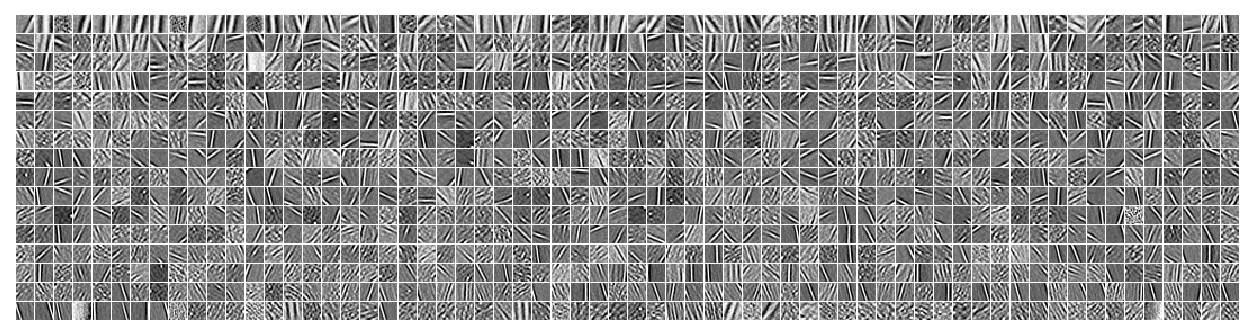

In [74]:
order = np.argsort(results['sf_0'].values)
_ = tr.model.show(order=order)

In [75]:
w_dec = tonp(tr.model.fc_dec.weight.data)
w_dec = w_dec.T.reshape(-1, 16, 16)
ids = np.argsort(results['sf_0'].values)

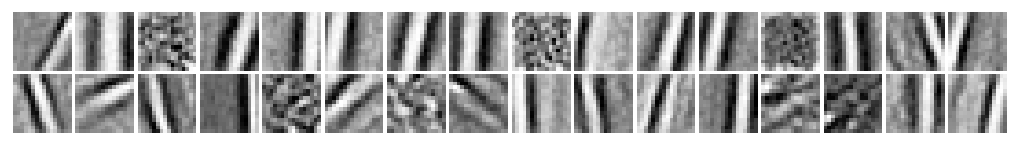

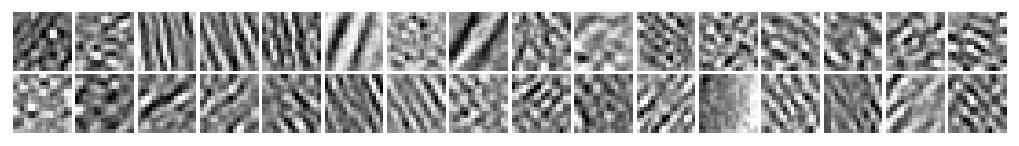

In [76]:
plot_weights(w_dec[ids[:32]], nrows=2, dpi=130)
plt.show()

plot_weights(w_dec[ids[-32:]], nrows=2, dpi=130)
plt.show()